In [35]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn import model_selection

from keras.layers.core import Dense, Dropout
from keras.layers.recurrent import GRU
from keras.models import Sequential, load_model
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

%matplotlib inline

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [12]:
df = pd.read_csv('D:/project/ml/course/deepai/dl_course/Stock-Prediction-RNN/prices_stock.csv', index_col=['date'])

In [13]:
df.head()

,symbol,open,close,low,high,volume
date,,,,,,
2016-01-05 00:00:00,WLTW,123.430000,125.839996,122.309998,126.250000,2163600.0
2016-01-06 00:00:00,WLTW,125.239998,119.980003,119.940002,125.540001,2386400.0
2016-01-07 00:00:00,WLTW,116.379997,114.949997,114.930000,119.739998,2489500.0
2016-01-08 00:00:00,WLTW,115.480003,116.620003,113.500000,117.440002,2006300.0
2016-01-11 00:00:00,WLTW,117.010002,114.970001,114.089996,117.330002,1408600.0


In [7]:
df.symbol.value_counts().head()

DLTR    1762
MDT     1762
WYNN    1762
BA      1762
JWN     1762
Name: symbol, dtype: int64

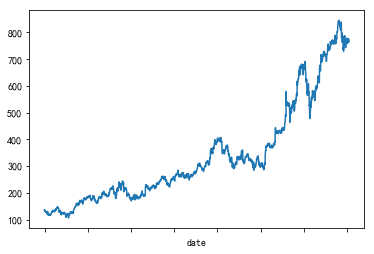

In [14]:
df[df['symbol']=='AMZN']['open'].plot()

In [123]:
target = df.loc[df['symbol']=='AMZN', ['open', 'low', 'high', 'close']]
target.index = pd.to_datetime(target.index)
target = target.iloc[(target.index>='2010-01-01')&(target.index<='2012-04-04')]
target.shape

(569, 4)

In [122]:
print(target.index.min(), target.index.max())

2010-01-04 2016-12-27


In [16]:
target.head()

,open,low,high,close
date,,,,
2010-01-04,136.250000,133.139999,136.610001,133.899994
2010-01-05,133.429993,131.809998,135.479996,134.690002
2010-01-06,134.600006,131.649994,134.729996,132.250000
2010-01-07,132.009995,128.800003,132.320007,130.000000
2010-01-08,130.559998,129.029999,133.679993,133.520004


In [124]:
target_shift = target.shift(-3)
target_shift.head()

,open,low,high,close
date,,,,
2010-01-04,132.009995,128.800003,132.320007,130.000000
2010-01-05,130.559998,129.029999,133.679993,133.520004
2010-01-06,132.619995,129.210007,132.800003,130.309998
2010-01-07,128.990005,126.550003,129.820007,127.349998
2010-01-08,127.900002,125.750000,129.710007,129.110001


In [125]:
target['label'] = target_shift['close']

In [126]:
target.tail()

,open,low,high,close,label
date,,,,,
2012-03-29,201.279999,200.630005,205.309998,204.610001,199.660004
2012-03-30,205.020004,201.869995,206.850006,202.509995,193.990005
2012-04-02,198.020004,197.000000,199.899994,198.050003,NaN
2012-04-03,198.240005,197.500000,202.389999,199.660004,NaN
2012-04-04,196.949997,192.360001,197.679993,193.990005,NaN


In [127]:
target = target[target['label'].notnull()]

In [128]:
target.head()

,open,low,high,close,label
date,,,,,
2010-01-04,136.250000,133.139999,136.610001,133.899994,130.000000
2010-01-05,133.429993,131.809998,135.479996,134.690002,133.520004
2010-01-06,134.600006,131.649994,134.729996,132.250000,130.309998
2010-01-07,132.009995,128.800003,132.320007,130.000000,127.349998
2010-01-08,130.559998,129.029999,133.679993,133.520004,129.110001


In [129]:
target.shape

(566, 5)

In [130]:
x,y = target[['open','low','high','close']], target['label']
x_scale = preprocessing.StandardScaler()
y_scale = preprocessing.StandardScaler()

n = 300

X_train, X_test, y_train, y_test = x[:n], x[n:], y[:n], y[n:]

index = X_test.index

X_train = x_scale.fit_transform(X_train.values)
X_test = x_scale.transform(X_test.values)

y_train = y_scale.fit_transform(y_train.values.reshape(-1,1))
y_test = y_scale.transform(y_test.values.reshape(-1,1))

X_train = X_train.reshape((-1,1,4))
X_test = X_test.reshape((-1,1,4))

In [61]:
index[:10]

Index(['2013-12-23', '2013-12-24', '2013-12-26', '2013-12-27', '2013-12-30',
       '2013-12-31', '2014-01-02', '2014-01-03', '2014-01-06', '2014-01-07'],
      dtype='object', name='date')

In [121]:
X_train.shape

(1000, 1, 4)

In [131]:
model = Sequential()
model.add(GRU(units=512, return_sequences=True, input_shape=(1,4)))
model.add(Dropout(0.2))
model.add(GRU(units=256))
model.add(Dropout(0.2))
model.add(Dense(1,activation='sigmoid'))
model.compile(loss='mse', optimizer='adam')

In [120]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru_9 (GRU)                  (None, 1, 512)            794112    
_________________________________________________________________
dropout_9 (Dropout)          (None, 1, 512)            0         
_________________________________________________________________
gru_10 (GRU)                 (None, 256)               590592    
_________________________________________________________________
dropout_10 (Dropout)         (None, 256)               0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 257       
Total params: 1,384,961
Trainable params: 1,384,961
Non-trainable params: 0
_________________________________________________________________


In [132]:
model.fit(X_train,y_train,batch_size=250, epochs=5, validation_split=0.1, verbose=1)


Train on 270 samples, validate on 30 samples
Epoch 1/5
270/270 [==============================] - 2s 8ms/step - loss: 1.3179 - val_loss: 0.5645
Epoch 2/5
270/270 [==============================] - 0s 359us/step - loss: 1.1603 - val_loss: 0.4339
Epoch 3/5
270/270 [==============================] - 0s 359us/step - loss: 1.0076 - val_loss: 0.3353
Epoch 4/5
270/270 [==============================] - 0s 396us/step - loss: 0.8641 - val_loss: 0.2688
Epoch 5/5
270/270 [==============================] - 0s 378us/step - loss: 0.7459 - val_loss: 0.2288


In [133]:
score = model.evaluate(X_test, y_test)
print('Score: {}'.format(score))
pred = model.predict(X_test)
pred = y_scale.inverse_transform(pred)
y_test = y_scale.inverse_transform(y_test)

266/266 [==============================] - 0s 188us/step
Score: 1.9170847889175988


In [134]:
y_test[-10:]

array([[192.399994],
       [195.039993],
       [202.869995],
       [205.440002],
       [201.160004],
       [204.610001],
       [202.509995],
       [198.050003],
       [199.660004],
       [193.990005]])

(array([ 6., 13., 72., 51., 36., 25., 33., 13., 12.,  5.]),
 array([160.970001 , 169.5440016, 178.1180022, 186.6920028, 195.2660034,
        203.840004 , 212.4140046, 220.9880052, 229.5620058, 238.1360064,
        246.710007 ]),
 <a list of 10 Patch objects>)

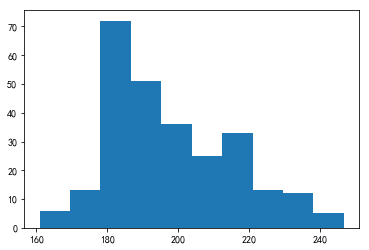

In [135]:
plt.hist(y_test)

(array([  2.,   5.,   1.,   0.,   4.,   3.,  23.,  49.,  65., 114.]),
 array([164.03373718, 164.61883698, 165.20393677, 165.78903656,
        166.37413635, 166.95923615, 167.54433594, 168.12943573,
        168.71453552, 169.29963531, 169.88473511]),
 <a list of 10 Patch objects>)

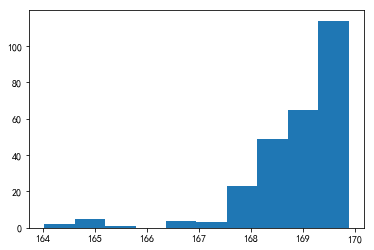

In [136]:
plt.hist(pred)

In [113]:
yhat[-10:]

array([[273.22208],
       [273.2047 ],
       [273.2863 ],
       [273.3256 ],
       [273.3018 ],
       [273.22327],
       [273.2354 ],
       [273.2569 ],
       [273.3049 ],
       [273.25385]], dtype=float32)

In [92]:
# plt.plot(index[-100:], yhat[-100:], label='pred')
def plot(x, y):
    f, ax = plt.subplots()
    ax.plot(x, y, label='truth')
    ax.legend()

    # years = mdates.YearLocator()   # every year
    months = mdates.MonthLocator()  # every month
    monthsFmt = mdates.DateFormatter('%Y%m')

    ax.xaxis.set_major_locator(months)
    ax.xaxis.set_major_formatter(monthsFmt)
    # ax.xaxis.set_minor_locator(months)

    ax.format_xdata = mdates.DateFormatter('%Y-%m-%d')
    # ax.format_ydata = price

    f.autofmt_xdate()

In [137]:
target.tail()

,open,low,high,close,label
date,,,,,
2012-03-26,196.479996,195.500000,202.970001,202.869995,204.610001
2012-03-27,203.589996,202.880005,209.850006,205.440002,202.509995
2012-03-28,206.139999,200.309998,207.000000,201.160004,198.050003
2012-03-29,201.279999,200.630005,205.309998,204.610001,199.660004
2012-03-30,205.020004,201.869995,206.850006,202.509995,193.990005


In [145]:
y_scale.inverse_transform(y_train[-10:])

array([[172.789993],
       [171.669998],
       [169.080002],
       [166.889999],
       [169.050003],
       [166.139999],
       [168.070007],
       [166.729996],
       [165.080002],
       [164.699997]])

In [138]:
y_test[-10:]

array([[192.399994],
       [195.039993],
       [202.869995],
       [205.440002],
       [201.160004],
       [204.610001],
       [202.509995],
       [198.050003],
       [199.660004],
       [193.990005]])

In [142]:
pred[-50:]

array([[169.03871],
       [168.89339],
       [168.72093],
       [168.78441],
       [169.0755 ],
       [169.20866],
       [169.13602],
       [169.17139],
       [167.65239],
       [168.14563],
       [168.64468],
       [168.61145],
       [168.49864],
       [168.63234],
       [168.57147],
       [168.61702],
       [168.94409],
       [169.02142],
       [168.84006],
       [167.97427],
       [168.2883 ],
       [168.41351],
       [168.2974 ],
       [168.02342],
       [168.07256],
       [167.87498],
       [168.28104],
       [168.322  ],
       [168.05005],
       [168.11963],
       [168.1141 ],
       [168.1758 ],
       [168.5087 ],
       [168.71626],
       [168.6712 ],
       [168.52821],
       [168.50996],
       [168.44067],
       [168.43893],
       [168.55681],
       [168.60616],
       [168.90868],
       [169.11919],
       [169.08768],
       [169.18343],
       [169.40143],
       [169.55507],
       [169.51553],
       [169.49808],
       [169.52446]],

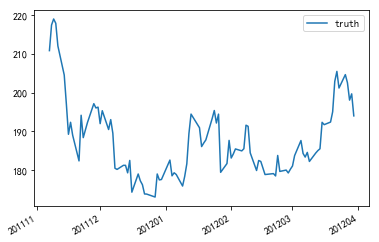

In [140]:
plot(index[-100:], y_test[-100:])

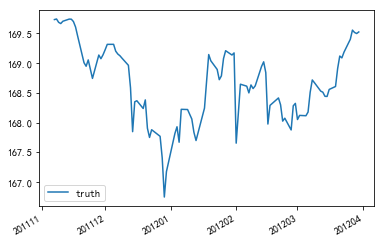

In [141]:
plot(index[-100:], pred[-100:])

# 总结
1. 对震荡可以预测，但是对趋势，无法预测
2. 预测结果，都在168，变化很小
3. 预测的策略问题，数据集如何划分
4. 可不可以自动生成股票价格
5. keras